In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.naive_bayes import BernoulliNB

# Sentiment Analysis

## Amazon

In [2]:
reviews = pd.read_csv('./amazon_cells_labelled.txt', sep='\t', header=None)
reviews.columns = ['review', 'score']

In [49]:
# lets determine which "buzzwords" are more frequent 
word_counts_positive = reviews.query("score == 1").review.str.split(expand=True).stack().value_counts()
word_counts_negative = reviews.query("score == 0").review.str.split(expand=True).stack().value_counts()
# get the words unique to negative review
words_negative = word_counts_negative.index.difference(word_counts_positive.index)
words_positive = word_counts_positive.index.difference(word_counts_negative.index)

In [53]:
x = word_counts_positive[words_positive].sort_values(ascending = False).head(20).index
pos_words = x.to_series().apply(str.lower).values
# also need to pull out the punctuation
pos_words

array(['great', 'works', 'love', 'best', 'works', 'good', 'nice',
       'working', 'nice', 'pretty', 'excellent', 'good.', 'fine', 'fine.',
       'great!', 'data', 'job', 'sturdy', 'far.', 'phone.'], dtype=object)

In [54]:
y = word_counts_negative[words_negative].sort_values(ascending = False).head(20).index
neg_words = y.to_series().apply(str.lower).values
neg_words

array(["don't", 'waste', 'not', 'worst', 'money', 'unit', "didn't", 'bad',
       'difficult', 'what', 'poor', 'poor.', "doesn't", 'return', 'week',
       'do', 'broke', 'stay', 'buying', 'unfortunately'], dtype=object)

These words are unique to each class:

### Positive
  1. great
  2. works
  3. love
  4. best
  5. good
  6. nice
  7. working
  8. excellent
  9. good
  10. fine
  11. sturdy

### Negative
  1. don't
  2. waste
  3. not
  4. worst
  5. didn't
  6. bad
  7. difficult
  8. poor
  9. doesn't
  10. return
  11. broke
  

In [56]:
pos_words = ['great','works','love','best',
             'good','nice','working','excellent',
             'good','fine','sturdy']
neg_words = ["don't","waste","not","worst",
             "didn't","bad","difficult","poor",
             "doesn't","return","broke"]

In [74]:
for word in neg_words:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    reviews[str(word)] = reviews.review.str.contains(
        ' ' + str(word) + ' ',
        case=False
    )
    
for word in pos_words:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    reviews[str(word)] = reviews.review.str.contains(
        ' ' + str(word) + ' ',
        case=False
    )

Let's add a few more.

In [42]:
# I would guess that positive reviews have more exclamation marks than negative ones
1 / (reviews.query("score == 0").review.str.contains("!").sum() / len(reviews))

27.027027027027028

In [41]:
1 / (reviews.query("score == 1").review.str.contains("!").sum() / len(reviews))

12.820512820512821

  * So essentially what this tells us is that 1 in every 12.8 **positive** reviews contain an exclamation mark, while only 1 in every 27 **negative** reviews contain an exclamation mark. Let's add this!
  * 1 in every 3 **positive** reviews is in all caps, while 2 in every 3 **negative** reviews are in all caps - so add this as well!

In [62]:
reviews['exclamation'] = reviews.review.str.contains("!")
reviews["allcaps"] = reviews.review.str.isupper()

In [63]:
data = reviews[neg_words + pos_words]
target = reviews['score']

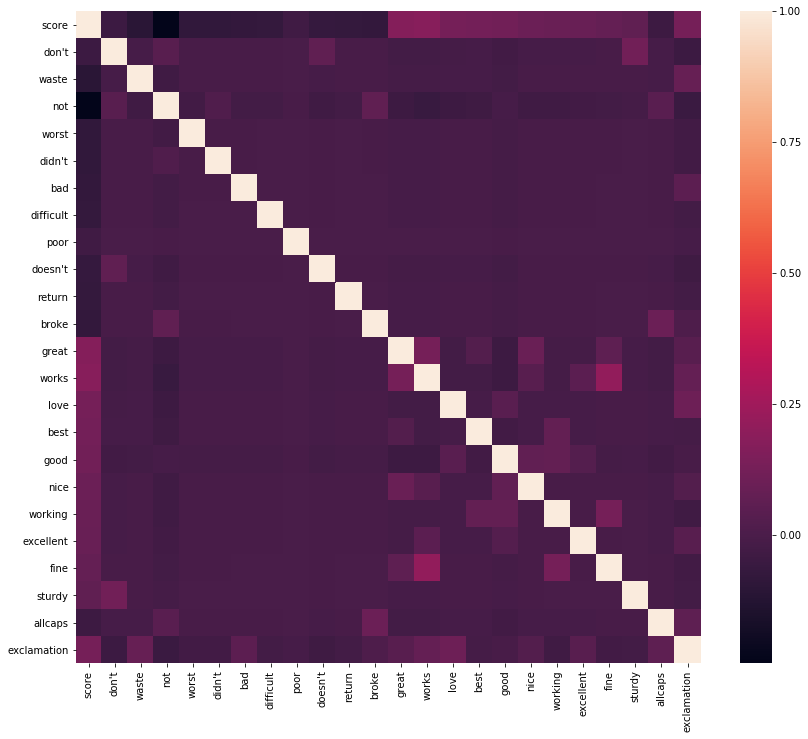

In [66]:
plt.figure(figsize=(14,12))
sns.heatmap(reviews.corr())
plt.show()

  * So our input words appear to be uncorrelated
  
  ### Model

In [71]:
# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

n = data.shape[0]
# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    n,
    (target != y_pred).sum()
))

correct = (n - (target != y_pred).sum())/n * 100
print("Accuracy: {}%".format(correct))

Number of mislabeled points out of a total 1000 points : 366
Accuracy: 63.4%


  * This model is roughly **63.4%**
  
  

# Now we will use the same model on other company reviews

## IMDB

In [72]:
imdb = pd.read_csv('./imdb_labelled.txt', sep='\t', header=None)
imdb.columns = ['review', 'score']

In [82]:
for word in neg_words:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    imdb[str(word)] = imdb.review.str.contains(
        ' ' + str(word) + ' ',
        case=False
    )
    
for word in pos_words:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    imdb[str(word)] = imdb.review.str.contains(
        ' ' + str(word) + ' ',
        case=False
    )
imdb['exclamation'] = imdb.review.str.contains("!")
imdb["allcaps"] = imdb.review.str.isupper()

In [83]:
data_imdb = imdb[neg_words + pos_words]
target_imdb = imdb['score']

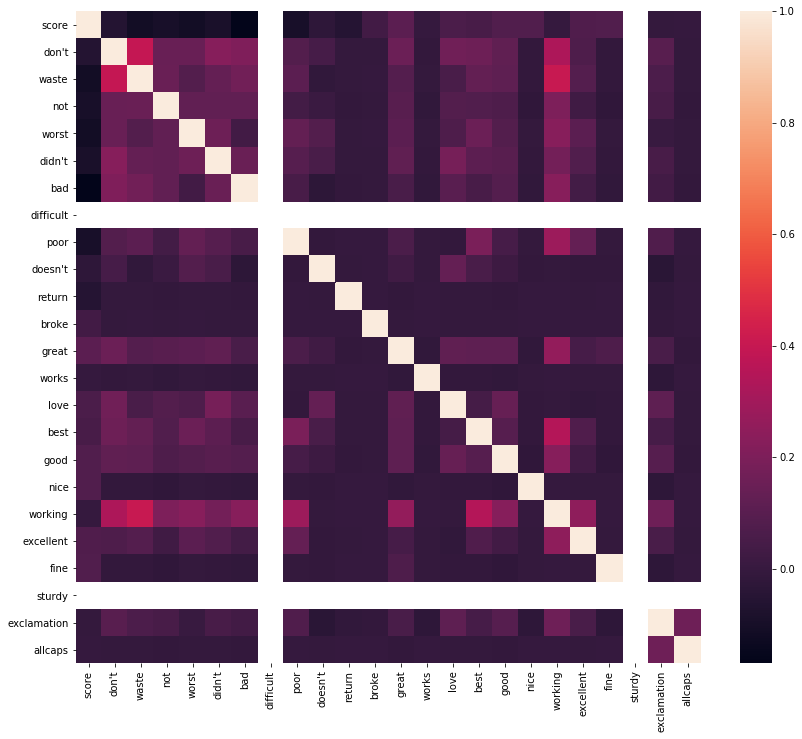

In [84]:
plt.figure(figsize=(14,12))
sns.heatmap(imdb.corr())
plt.show()

  * So difficult and sturdy do not show up in any IMDB reviews, and there are a few more words that are correlated (which could be an issue for our model, however none of the correlations appear to be greater than 0.5)

In [85]:
# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data_imdb, target_imdb)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data_imdb)

n = data_imdb.shape[0]
# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    n,
    (target_imdb != y_pred).sum()
))

correct = (n - (target_imdb != y_pred).sum())/n * 100
print("Accuracy: {}%".format(correct))

Number of mislabeled points out of a total 748 points : 296
Accuracy: 60.42780748663101%


* This model is roughly **60.4%** accurate

## Yelp

In [87]:
yelp = pd.read_csv('./yelp_labelled.txt', sep='\t', header=None)
yelp.columns = ['review', 'score']

In [88]:
for word in neg_words:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    yelp[str(word)] = yelp.review.str.contains(
        ' ' + str(word) + ' ',
        case=False
    )
    
for word in pos_words:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    yelp[str(word)] = yelp.review.str.contains(
        ' ' + str(word) + ' ',
        case=False
    )
yelp['exclamation'] = yelp.review.str.contains("!")
yelp["allcaps"] = yelp.review.str.isupper()

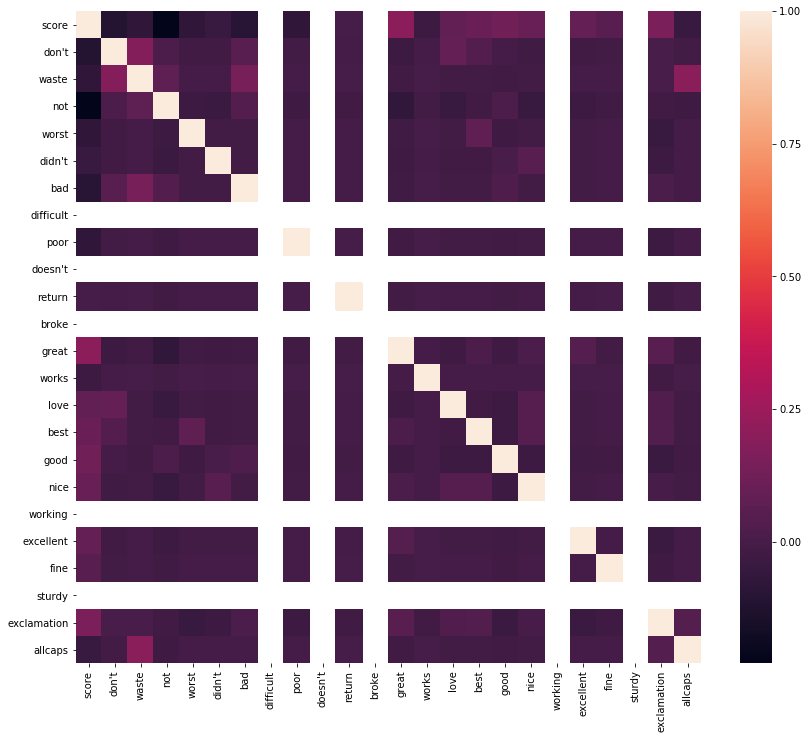

In [90]:
plt.figure(figsize=(14,12))
sns.heatmap(yelp.corr())
plt.show()

  * Yelp reviews do not contain the words difficult, doesn't, broke, working or sturdy
  * otherwise appear to be uncorrelated

In [91]:
data_yelp = yelp[neg_words + pos_words]
target_yelp = yelp['score']

In [92]:
# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data_yelp, target_yelp)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data_yelp)

n = data_yelp.shape[0]
# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    n,
    (target_yelp != y_pred).sum()
))

correct = (n - (target_yelp != y_pred).sum())/n * 100
print("Accuracy: {}%".format(correct))

Number of mislabeled points out of a total 1000 points : 391
Accuracy: 60.9%


  * This model is roughly **60.9%** accurate
  
  # Conclusion
  
  We constructed a Naive Bayes classification model by simply using the top frequently used words that were unique to positive and negative reviews, as well as if a review contains an exclamation mark and if the review is all caps (using Amazon reviews). Here were the accuracy rates for each dataset:
    1. Amazon: 63.4
    2. IMDB: 60.4
    3. Yelp: 60.9
    
  It is not surprising that the model that we trained using top keywords among Amazon reviews is less accurate when predicting the sentiment for IMDB and Yelp reviews, however the rates are quite similar.